# TinyML IR-Sensor 

## 1. Set the environment 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install tensorflow==2.0.0-beta0 #Install Tensor Flow
import tensorflow as tf

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## 2. Data Preparation 

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

url = "/content/drive/MyDrive/dataset.csv"
#url = 'https://raw.githubusercontent.com/SSV-embedded/TinyML_IR-Sensor/main/dataset.csv'

#there has to be a more elegant way of doing this...
names = ["Date", "data0", "data1", "data2", "data3", "data4", "data5", "data6", \
         "data7", "data8", "data9", "data10", "data11", "data12", "data13", "data14", \
         "data15", "data16", "data17", "data18", "data19", "data20", "data21", "data22", \
         "data23", "data24", "data25", "data26", "data27", "data28", "data29", "data30", \
         "data31", "data32", "data33", "data34", "data35", "data36", "data37", "data38", \
         "data39", "data40", "data41", "data42", "data43", "data44", "data45", "data46",\
         "data47", "data48", "data49", "data50", "data51", "data52", "data53", "data54", \
         "data55", "data56", "data57", "data58", "data59", "data60", "data61", "data62", \
         "data63", "label"]

num_classes=2
input = 64 

df = pd.read_csv(url, header=None, names=names, parse_dates=True, sep=',')
df["Date"] = pd.to_datetime(df["Date"]) 
df.index = df["Date"]
del df["Date"]

print(df)

                     data0  data1  data2  data3  ...  data61  data62  data63  label
Date                                             ...                               
2021-06-01 07:01:29  22.75  23.00  23.00  23.00  ...   22.75   23.00   23.25      0
2021-06-01 07:01:30  23.00  22.75  23.50  22.75  ...   22.75   22.50   23.00      0
2021-06-01 07:01:31  22.75  22.50  23.25  22.25  ...   22.50   22.50   23.25      0
2021-06-01 07:01:32  22.75  22.50  22.75  22.25  ...   22.25   23.25   23.00      0
2021-06-01 07:01:33  22.75  22.50  22.75  22.25  ...   22.50   23.00   22.50      0
...                    ...    ...    ...    ...  ...     ...     ...     ...    ...
2021-06-07 07:14:54  25.75  26.50  29.00  29.75  ...   29.75   29.25   28.25      1
2021-06-07 07:14:55  26.00  26.25  28.75  29.75  ...   30.75   29.00   28.50      1
2021-06-07 07:14:57  25.50  26.00  28.50  29.50  ...   30.00   28.25   27.75      1
2021-06-07 07:14:58  25.25  26.25  28.50  29.50  ...   30.00   28.25   27.50

In [3]:
#Separate labels from the dataset 
df_label =  pd.concat([df.pop(x) for x in ['label']], axis = 1)

#Debug print
#print(df.head(10))
#print(df_label.head(10))

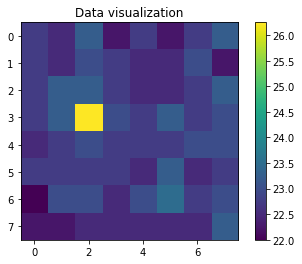

In [4]:
import numpy as np 
#Select row from the dataset which will be visualized
row = 2
data =df[row:row+1]
data = np.array(data, dtype = np.float32 )

i_size=np.sqrt(data.size)
i_size=np.array(i_size, dtype=np.int)
data = np.reshape(data, (i_size, i_size))


plt.imshow(data, interpolation='nearest')
plt.title('Data visualization')
plt.colorbar()
plt.show()
#print(train_labels[row:row+1])

In [5]:
min = df.min().min()
max = df.max().max()

print("min:", min)
print("max:", max)
df_norm = (df - min) / (max - min) 

print(df_norm.head())

min: 21.75
max: 51.0
                        data0     data1     data2  ...    data61    data62    data63
Date                                               ...                              
2021-06-01 07:01:29  0.034188  0.042735  0.042735  ...  0.034188  0.042735  0.051282
2021-06-01 07:01:30  0.042735  0.034188  0.059829  ...  0.034188  0.025641  0.042735
2021-06-01 07:01:31  0.034188  0.025641  0.051282  ...  0.025641  0.025641  0.051282
2021-06-01 07:01:32  0.034188  0.025641  0.034188  ...  0.017094  0.051282  0.042735
2021-06-01 07:01:33  0.034188  0.025641  0.034188  ...  0.025641  0.042735  0.025641

[5 rows x 64 columns]


In [6]:
#Set Dataset 
train_dataset = df_norm.sample(frac=0.8, random_state=0)
test_dataset = df_norm.drop(train_dataset.index)

#Set Labels 
train_labels = df_label.sample(frac=0.8, random_state=0)
test_labels = df_label.drop(train_dataset.index)

#Debug print
#print(train_labels)
#print(train_dataset)

## 3. Train the model


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

model = tf.keras.Sequential([
      layers.Dense(num_classes, activation = 'sigmoid', input_shape=(input,)),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 130       
Total params: 130
Trainable params: 130
Non-trainable params: 0
_________________________________________________________________


In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(lr= 0.005), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy'],
)

In [9]:
history = model.fit(
    train_dataset,
    to_categorical(train_labels),
    validation_split=0.2, 
    epochs = 20, 
    batch_size = 32, 
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 128 samples, validate on 33 samples
Epoch 1/20
128/128 [==============================] - 0s 1ms/sample - loss: 0.6680 - accuracy: 0.4922 - val_loss: 0.6277 - val_accuracy: 0.5455
Epoch 2/20
128/128 [==============================] - 0s 113us/sample - loss: 0.6339 - accuracy: 0.4922 - val_loss: 0.5940 - val_accuracy: 0.5455
Epoch 3/20
128/128 [==============================] - 0s 118us/sample - loss: 0.6095 - accuracy: 0.4922 - val_loss: 0.5712 - val_accuracy: 0.5455
Epoch 4/20
128/128 [==============================] - 0s 156us/sample - loss: 0.5983 - accuracy: 0.4922 - val_loss: 0.5535 - val_accuracy: 0.5455
Epoch 5/20
128/128 [==============================] - 0s 117us/sample - loss: 0.5829 - accuracy: 0.4922 - val_loss: 0.5398 - val_accuracy: 0.5455
Epoch 6/20
128/128 [==============================] - 0s 121us/sample - loss: 0.5709 - accuracy: 0.4922 - val_loss: 0.5274 - val_accu

In [10]:
model.evaluate(
    test_dataset, 
    to_categorical(test_labels)
)

40/40 [==============================] - 0s 718us/sample - loss: 0.3726 - accuracy: 1.0000


[0.3725602090358734, 1.0]

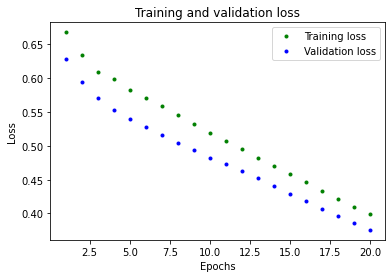

In [11]:
#Graphing the History

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs= range(1,len(loss)+1)

plt.plot(epochs, loss, 'g.', label= 'Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show() 

In [12]:
model.save("/content/IR_Sensor.h5")

## 4. Convert the Model to a Tiny ML & Classification


In [13]:
import tensorflow as tf 
from tensorflow import keras
!pip install 'h5py<3.0.0'

model = keras.models.load_model("/content/IR_Sensor.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert() 
open('IR_Sensor.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Converted 2 variables to const ops.


1320

In [14]:
import numpy as np 
import pandas as pd

url = "/content/drive/MyDrive/data.csv"

#there has to be a more elegant way of doing this...
names = ["Date", "data0", "data1", "data2", "data3", "data4", "data5", "data6", \
         "data7", "data8", "data9", "data10", "data11", "data12", "data13", "data14", \
         "data15", "data16", "data17", "data18", "data19", "data20", "data21", "data22", \
         "data23", "data24", "data25", "data26", "data27", "data28", "data29", "data30", \
         "data31", "data32", "data33", "data34", "data35", "data36", "data37", "data38", \
         "data39", "data40", "data41", "data42", "data43", "data44", "data45", "data46",\
         "data47", "data48", "data49", "data50", "data51", "data52", "data53", "data54", \
         "data55", "data56", "data57", "data58", "data59", "data60", "data61", "data62", \
         "data63"]

num_classes=2
input = 64 

df_val = pd.read_csv(url, header=None, names=names, parse_dates=True, sep=',')
df_val["Date"] = pd.to_datetime(df_val["Date"]) 
df_val.index = df_val["Date"]
del df_val["Date"]

val_data = np.array(df_val, dtype = np.float32 )
val_data = np.reshape(val_data, (1,input))

#Normalize the data first. Min and max have already been determined during the Data Preparation 
min = 21.75
max = 51.0
val= (val_data - min) / (max - min) 

In [15]:
interpreter = tf.lite.Interpreter(model_path="IR_Sensor.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#print("Input Details:", input_details)
#print("Output shape:", output_details[0]['shape']) 

interpreter.set_tensor(interpreter.get_input_details()[0]["index"], val)
interpreter.invoke()
output = interpreter.get_tensor(output_details[0]['index'])
pred_tiny = np.argmax(output)

ts = np.array(df_val.index)
prediction = pd.DataFrame({'Date':ts, 'Prediction': pred_tiny})
prediction["Date"] = pd.to_datetime(prediction["Date"]) 
prediction.index = prediction["Date"]
del prediction["Date"]

print(prediction)

                     Prediction
Date                           
2021-06-01 07:01:37           0
